# Introduction

In [ ]:
"""
What? Linear and non-linear manifold learning

PCA does not perform so well when there are nonlinear relationships within the data; manifold learning can help 
in this case. Think of a sheet of paper: this is a 2D object that lives in our familiar 3D world, and can be bent 
or rolled in 2D. In the parlance of manifold learning, we can think of this sheet as a 2D manifold embedded in 
three-dimensional space. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the
embedding into the three-dimensional space is no longer linear. Manifold learning algorithms would seek to learn 
about the fundamental two- dimensional nature of the paper, even as it is contorted to fill the three-dimensional
space. 

VanderPlas, Jake. Python data science handbook: Essential tools for working with data. "O'Reilly Media, Inc.", 2016.
https://github.com/jakevdp/PythonDataScienceHandbook
"""

# Import libraries/modules

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
import numpy as np
from matplotlib.image import imread
from sklearn.metrics import pairwise_distances 
from sklearn.manifold import MDS
from mpl_toolkits import mplot3d
from sklearn.manifold import LocallyLinearEmbedding

# Manifold Learning: “HELLO”

In [7]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)    
    plt.close(fig)
    # Open this PNG and draw random points from it
    data = imread('hello.png')[::-1, :, 0].T 
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T 
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1]) 
    X = X[:N]
    return X[np.argsort(X[:, 0])]

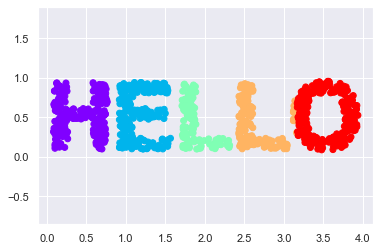

In [8]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

# Multidimensional Scaling (MDS)

In [ ]:
"""

"""

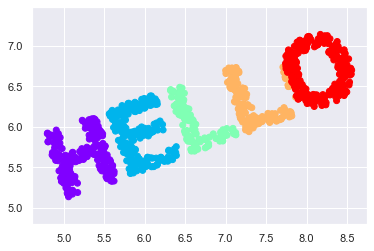

In [10]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [ ]:
"""
If we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally 
the same. This tells us that the x and y values are not necessarily fundamental to the relation‐ ships in the data.
What is fundamental, in this case, is the distance between each point and the other points in the dataset.
"""

In [12]:
D = pairwise_distances(X)
D.shape

(1000, 1000)

In [ ]:
"""
For our N=1,000 points, we obtain a 1,000×1,000 matrix, which can be visualized as
"""

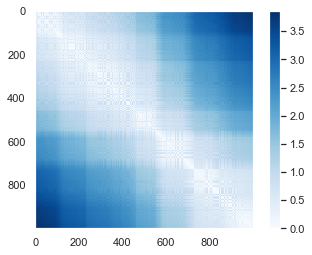

In [13]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [ ]:
"""
Now it comes the cool thing. The distance matrix for our rotated and translated data is the same.
"""

In [14]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

In [ ]:
"""
This distance matrix gives us a representation of our data that is invariant to rotations and translations, 
but the visualization of the matrix is not entirely intuitive. 

Further, while computing this distance matrix from the (x, y) coordinates is straight‐ forward, transforming 
the distances back into x and y coordinates is rather difficult. This is exactly what the multidimensional 
scaling algorithm aims to do: given a dis‐ tance matrix between points, it recovers a D-dimensional coordinate
representation of the data. Let’s see how it works for our distance matrix, using the precomputed dissimilarity 
to specify that we are passing a distance matrix
"""

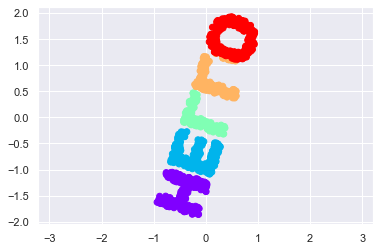

In [17]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1) 
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [ ]:
"""
The MDS algorithm recovers one of the possible two-dimensional coordinate repre‐ sentations of our data, 
using only the N × N distance matrix describing the relation‐ ship between the data points.
"""

# MDS as Manifold Learning

In [ ]:
"""
The usefulness of this becomes more apparent when we consider the fact that dis‐ tance matrices can be computed 
from data in any dimension. So, for example, instead of simply rotating the data in the two-dimensional plane, 
we can project it into three dimensions using the following function (essentially a three-dimensional generalization
of the rotation matrix used earlier)
"""

In [18]:
def random_projection(X, dimension=3, rseed=42): 
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension) 
    e, V = np.linalg.eigh(np.dot(C, C.T)) 
    return np.dot(X, V[:X.shape[1]])

In [19]:
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

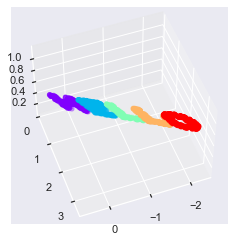

In [21]:
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim=70, elev=50)

In [ ]:
"""
We can now ask the MDS estimator to input this three-dimensional data, compute the distance matrix, and then 
determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation 
of the original data
"""

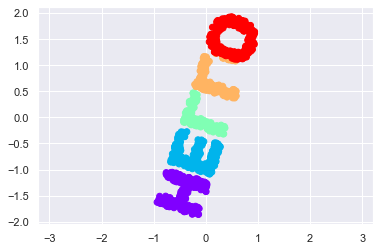

In [23]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

# Nonlinear embeddings - where MDS fails

In [ ]:
"""
Our discussion so far has considered linear embeddings, which essentially consist of rotations, translations, 
and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear—that 
is, when it goes beyond this simple set of operations. Consider the following embedding, which takes the input and
contorts it into an “S” shape in three dimensions:
"""

In [24]:
def make_hello_s_curve(X): 
    t=(X[:,0]-2)*0.75*np.pi
    x = np.sin(t)
    y=X[:,1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

In [25]:
XS = make_hello_s_curve(X)

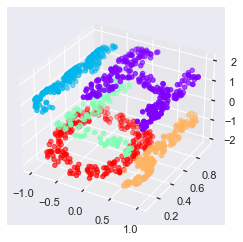

In [27]:
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

In [ ]:
"""
It has been wrapped up into the shape of an “S”. If we try a simple MDS algorithm on this data, it is not able to 
“unwrap” this nonlin‐ ear embedding, and we lose track of the fundamental relationships in the embedded manifold. 
"""

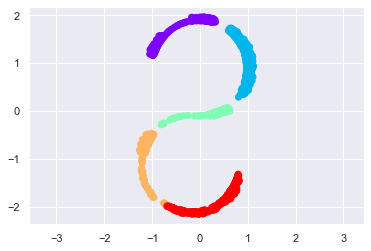

In [28]:
model = MDS(n_components=2, random_state=2) 
outS = model.fit_transform(XS) 
plt.scatter(outS[:, 0], outS[:, 1], **colorize) 
plt.axis('equal');

In [ ]:
"""
The MDS algorithm applied to the nonlinear data; it fails to recover the underlying structure. Instead 
throws out the original y-axis!
"""

# Nonlinear Manifolds: Locally Linear Embedding

In [ ]:
"""
The source of the problem is that MDS tries to preserve distances between faraway points when constructing the
embedding. But what if we instead modified the algorithm such that it only preserves distances between nearby 
points? The resulting embedding would be closer to what we want.
"""

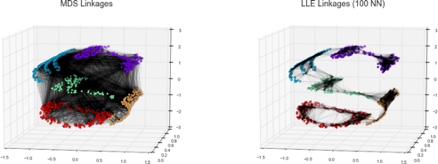

In [ ]:
"""
On the left is a representation of the model used by MDS: it tries to preserve the dis‐ tances between each pair 
of points in the dataset. On the right is a representation of the model used by a manifold learning algorithm 
called locally linear embedding (LLE): rather than preserving all distances, it instead tries to preserve only 
the distan‐ ces between neighboring points: in this case, the nearest 100 neighbors of each point.
"""

In [30]:
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                                   eigen_solver='dense')
out = model.fit_transform(XS)

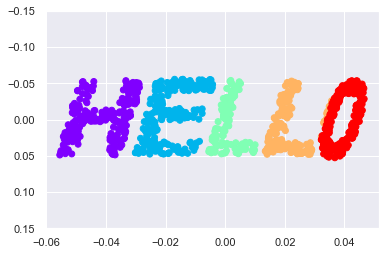

In [31]:
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

In [ ]:
"""
The result remains somewhat distorted compared to our original manifold, but cap‐ tures the essential relationships 
in the data!
"""